# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Необходимо построить модель с целевым значением метрики *F1* 0.59.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

#metrics
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

### Изучение данных

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


**Вывод**

В датасете 12 колонок и 10000 строк. В колонке `Tenure` наблюдаются пропуски.

В данных 11 признаков, целевой признак факт ухода клиента (1 или 0). Колонки `Surname`, `Geography` и `Gender` содержат категориальные признаки, остальные - численные.
Необходимо построить модель задачи классификации, которая спрогнозирует уйдет ли клиент в ближайшее время или нет. 

Признаки
* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

Целевой признак
* Exited — факт ухода клиента

### Предобработка данных

Установим первую колонку в качестве индекса, чем она фактически и является

In [4]:
data.set_index('RowNumber', inplace=True)

Проверим на наличие явных дубликатов

In [5]:
data.duplicated().sum()

0

Пропусков в данных (в колонке `Tenure`) менее 10% от общих данных, поэтому принято решение удалить пропуски

In [6]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 1 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       9091 non-null   int64  
 1   Surname          9091 non-null   object 
 2   CreditScore      9091 non-null   int64  
 3   Geography        9091 non-null   object 
 4   Gender           9091 non-null   object 
 5   Age              9091 non-null   int64  
 6   Tenure           9091 non-null   float64
 7   Balance          9091 non-null   float64
 8   NumOfProducts    9091 non-null   int64  
 9   HasCrCard        9091 non-null   int64  
 10  IsActiveMember   9091 non-null   int64  
 11  EstimatedSalary  9091 non-null   float64
 12  Exited           9091 non-null   int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 994.3+ KB


Столбцы с информацией о фамилии `Surname` и идентификатор клиента `CustomerId` очевидно никак не поможет в решение задачи, поэтому принято решение его удалить

In [7]:
data.drop(['Surname', 'CustomerId'], axis=1, inplace=True)
data.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

**Вывод**

Данные подготовлены: удалены нерелевантные колонки и пустые строки, выполнена проверка на дубликаты.

### Подготовка признаков

Преобразуем категориальные признаки в численные с помощью техники прямого кодирования OHE

In [8]:
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 1 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        9091 non-null   int64  
 1   Age                9091 non-null   int64  
 2   Tenure             9091 non-null   float64
 3   Balance            9091 non-null   float64
 4   NumOfProducts      9091 non-null   int64  
 5   HasCrCard          9091 non-null   int64  
 6   IsActiveMember     9091 non-null   int64  
 7   EstimatedSalary    9091 non-null   float64
 8   Exited             9091 non-null   int64  
 9   Geography_Germany  9091 non-null   uint8  
 10  Geography_Spain    9091 non-null   uint8  
 11  Gender_Male        9091 non-null   uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 736.9 KB


### Раделим данные на выборки

Сперва выделим из данных целевой признак и остальные признаки

In [9]:
target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)

В наличии нет скрытой тестовой выборке. Значит данные необходимо разбить на три части: обучающую, валидационную и тестовую. Разобъем исходные данные в соотношении 3:1:1

Сперва выделим тестовую выборку в размере 20% от основной.

In [10]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)

Затем поделим получившуюся обучающую выборку непосредственно на обучающую и валидационную (25%)

In [11]:
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=0.25, random_state=12345)

Проверим размеры получившихся выборок

In [12]:
print(features_train.shape)
print(target_train.shape)

(5454, 11)
(5454,)


In [13]:
print(features_valid.shape)
print(target_valid.shape)

(1818, 11)
(1818,)


In [14]:
print(features_test.shape)
print(target_test.shape)

(1819, 11)
(1819,)


**Вывод**

Исходные данные разделены на обучающую, валидационную и тестовую выборку в соотношении 3:1:1

### Масштабирование признаков

В данных присутствуют признаки с разными масштабами. Для дальнейшего исследования необходимо стандартизировать данные.

Воспользуемся структурой StandardScaler из библиотеки sklearn. Создадим объект этой структуры и настроим его на обучающих данных.

In [15]:
scaler = StandardScaler()
scaler.fit(features_train)

StandardScaler()

Преобразуем обучающую, валидационную и тестовые выборки функцией transform(). 

In [16]:
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)

In [17]:
pd.DataFrame(features_train, columns=features.columns).head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,-0.203819,0.471273,0.352316,0.786022,0.782369,-1.545860,-1.016640,-0.357205,-0.579750,1.763526,-1.089828
1,-0.357513,-0.384930,-1.373506,-1.230577,0.782369,0.646889,0.983632,-1.671048,-0.579750,-0.567046,-1.089828
2,0.175290,-0.289797,-0.683177,-1.230577,0.782369,0.646889,-1.016640,-1.119181,-0.579750,-0.567046,0.917576
3,0.349476,1.708010,0.007151,1.379462,-0.914942,-1.545860,-1.016640,-1.569064,1.724882,-0.567046,-1.089828
4,0.902771,-0.289797,1.387809,-1.230577,-0.914942,-1.545860,0.983632,1.543790,-0.579750,-0.567046,0.917576


**Вывод**

Признаки масштабированы и пригодны для дальнейших исследований

## Исследование задачи

Перед нами стоит задача на основе исторических данные о поведении клиентов и расторжении договоров с банком научиться прогнозировать уйдёт клиент из банка в ближайшее время или нет.

Таким образом необходимо построить модель для задачи классификации.

Для исследования возьмем три модели из библиотеки `sklearn`:

* DecisionTreeClassifier
* RandomForestClassifier 
* LogisticRegression 

### Баланс классов

Исследуем дисбаланс классов

In [18]:
data_ohe['Exited'].value_counts(normalize=True)

0    0.796062
1    0.203938
Name: Exited, dtype: float64

На лицо явный дисбаланс классов в пользу отрицательного. Соотношение 4:1

### Модели без учета дисбаланса

Для начала проверим метрику F1 на несбалансированной выборке с помощью моделей, подбирая оптимальные гиперпараметры

#### DecisionTreeClassifier

Найдем лучшую модель меняя гиперпарамметр глубины дерева от 1 до 5 и проверяя `F1` на валидационной выборке

In [19]:
%time

best_DecisionTree_model = None
best_DecisionTree_f1_score_valid = 0
best_DecisionTree_depth = 0

for depth in range(1,6):
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    DecisionTree_f1_score_valid = f1_score(target_valid, predictions)
    
    if DecisionTree_f1_score_valid > best_DecisionTree_f1_score_valid:
        best_DecisionTree_model = model
        best_DecisionTree_f1_score_valid = DecisionTree_f1_score_valid
        best_DecisionTree_depth = depth
        
print("F1 наилучшей модели на валидационной выборке:", best_DecisionTree_f1_score_valid, "Глубина дерева:", best_DecisionTree_depth)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.63 µs
F1 наилучшей модели на валидационной выборке: 0.5571658615136877 Глубина дерева: 5


Оптимальная глубина дерева 5. Метрика F1 = 0.53, что не удовлетворяет условию.

Проверим метрику ROC AUC

In [20]:
probabilities_valid = best_DecisionTree_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
DecisionTree_roc_auc_score_valid = roc_auc_score(target_valid, probabilities_one_valid)

print("ROC AUC модели на валидационной выборке:", DecisionTree_roc_auc_score_valid)

ROC AUC модели на валидационной выборке: 0.8036164551626549


#### RandomForestClassifer

Найдем лучшую модель случайного леса меняя гиперпарамметр количества деревьев и глубины проверяя `F1` на валидационной выборке

In [21]:
%time

best_RandomForest_model = None
best_RandomForest_f1_score_valid = 0
best_RandomForest_depth = 0
best_n_est = 0

for est in range(10, 51, 10):
    for depth in range(1,6):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=42)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        RandomForest_f1_score_valid = f1_score(target_valid, predictions)
        
        if RandomForest_f1_score_valid > best_RandomForest_f1_score_valid:
            best_RandomForest_model = model
            best_RandomForest_f1_score_valid = RandomForest_f1_score_valid
            best_RandomForest_depth = depth
            best_n_est = est

print("F1 наилучшей модели на валидационной выборке:", best_RandomForest_f1_score_valid, "Количество деревьев:", best_n_est, "Глубина дерева:", best_RandomForest_depth)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs
F1 наилучшей модели на валидационной выборке: 0.49811320754716987 Количество деревьев: 10 Глубина дерева: 5


Оптимальное количество деревьев 10 с глубиной 5. Метрика F1 = 0.52 ниже заданной по условию.

Проверим метрику ROC AUC

In [22]:
probabilities_valid = best_RandomForest_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
RandomForest_roc_auc_score_valid = roc_auc_score(target_valid, probabilities_one_valid)

print("ROC AUC модели на валидационной выборке:", RandomForest_roc_auc_score_valid)

ROC AUC модели на валидационной выборке: 0.8298267699348176


#### LogisticRegression

Обучим модель логистической регрессии и проверим `F1` на валидационной выборке

In [23]:
%time

LogisticRegression_model = LogisticRegression(solver='lbfgs', random_state=42)
LogisticRegression_model.fit(features_train, target_train)
predictions = LogisticRegression_model.predict(features_valid)
LogisticRegression_f1_score_valid = f1_score(target_valid, predictions)

print("F1 модели на валидационной выборке:", LogisticRegression_f1_score_valid)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs
F1 модели на валидационной выборке: 0.3004115226337448


F1 модели на валидационной выборке 0.34 ниже заданной по условию

Проверим метрику ROC AUC

In [24]:
probabilities_valid = LogisticRegression_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
LogisticRegression_roc_auc_score_valid = roc_auc_score(target_valid, probabilities_one_valid)

print("ROC AUC модели на валидационной выборке:", LogisticRegression_roc_auc_score_valid)

ROC AUC модели на валидационной выборке: 0.7724525433169247


#### Сводная таблица

Для удобства сведем результаты исследования в одну таблицу

In [25]:
pd.DataFrame([[best_DecisionTree_f1_score_valid, DecisionTree_roc_auc_score_valid],
              [best_RandomForest_f1_score_valid, RandomForest_roc_auc_score_valid],
              [LogisticRegression_f1_score_valid, LogisticRegression_roc_auc_score_valid]],
             index=['DecisionTree', 'RandomForest', 'LogisticRegression'],
             columns=['f1_score_valid', 'ROC_AUC_valid']).sort_values(by='f1_score_valid', ascending=False)

,f1_score_valid,ROC_AUC_valid
DecisionTree,0.557166,0.803616
RandomForest,0.498113,0.829827
LogisticRegression,0.300412,0.772453


**Вывод**

Метрика F1 на несбалансированной выборке ниже целевой 0.59 для всех моделей, что говорит о том, что положительный класс плохо прогнозируется по одной из шкал (Recall или Precision).

## Борьба с дисбалансом

В данных наблюдается дисбаланс, что плохо сказывается на обучении модели.

Для обработки дисбаланса применим разные методы для обучающей выборки:
* взвешивание классов
* upsampling
* downsampling

Предварительно напишем функции для увеличения и уменьшения выборки

In [26]:
def upsample(features, target, multiplicator):
    features_zeros = pd.DataFrame(features[target == 0])
    features_ones = pd.DataFrame(features[target == 1])
    target_zeros = pd.Series(target[target == 0])
    target_ones = pd.Series(target[target == 1])
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * multiplicator)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * multiplicator)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=42)
    
    return features_upsampled, target_upsampled

In [27]:
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4)

In [28]:
print(features_train_upsampled.shape)
print(target_train_upsampled.shape)

(8811, 11)
(8811,)


In [29]:
def downsample(features, target, frac):
    features_zeros = pd.DataFrame(features[target == 0]).sample(frac=frac, random_state=42)
    features_ones = pd.DataFrame(features[target == 1])
    target_zeros = pd.Series(target[target == 0]).sample(frac=frac, random_state=42)
    target_ones = pd.Series(target[target == 1])
    
    features_downsampled = pd.concat([features_zeros] + [features_ones])
    target_downsampled = pd.concat([target_zeros] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=42)
    
    return features_downsampled, target_downsampled

In [30]:
features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, 0.25)

In [31]:
print(features_train_downsampled.shape)
print(target_train_downsampled.shape)

(2203, 11)
(2203,)


### Обучение моделей с учетом дисбаланса классов

#### DecisionTreeClassifier

##### Взвешивание классов

In [32]:
%time

best_DecisionTree_model_weighted = None
best_DecisionTree_f1_score_valid_weighted = 0
best_DecisionTree_depth = 0

for depth in range(1,6):
    model = DecisionTreeClassifier(max_depth=depth, random_state=42, class_weight='balanced')
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    DecisionTree_f1_score_valid = f1_score(target_valid, predictions)
    
    if DecisionTree_f1_score_valid > best_DecisionTree_f1_score_valid_weighted:
        best_DecisionTree_model_weighted = model
        best_DecisionTree_f1_score_valid_weighted = DecisionTree_f1_score_valid
        best_DecisionTree_depth = depth
        
print("F1 наилучшей модели на валидационной выборке:", best_DecisionTree_f1_score_valid_weighted, "Глубина дерева:", best_DecisionTree_depth)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
F1 наилучшей модели на валидационной выборке: 0.5345016429353778 Глубина дерева: 5


In [33]:
probabilities_valid = best_DecisionTree_model_weighted.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
DecisionTree_roc_auc_score_valid_weighted = roc_auc_score(target_valid, probabilities_one_valid)

print("ROC AUC модели на валидационной выборке:", DecisionTree_roc_auc_score_valid_weighted)

ROC AUC модели на валидационной выборке: 0.8074447906787698


##### Upsampling

In [34]:
%time

best_DecisionTree_model_upsampled = None
best_DecisionTree_f1_score_valid_upsampled = 0
best_DecisionTree_depth = 0

for depth in range(1,6):
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(features_train_upsampled, target_train_upsampled)
    predictions = model.predict(features_valid)
    DecisionTree_f1_score_valid = f1_score(target_valid, predictions)
    
    if DecisionTree_f1_score_valid > best_DecisionTree_f1_score_valid_upsampled:
        best_DecisionTree_model_upsampled = model
        best_DecisionTree_f1_score_valid_upsampled = DecisionTree_f1_score_valid
        best_DecisionTree_depth = depth
        
print("F1 наилучшей модели на валидационной выборке:", best_DecisionTree_f1_score_valid_upsampled, "Глубина дерева:", best_DecisionTree_depth)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 32.9 µs
F1 наилучшей модели на валидационной выборке: 0.5345016429353778 Глубина дерева: 5


In [35]:
probabilities_valid = best_DecisionTree_model_upsampled.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
DecisionTree_roc_auc_score_valid_upsampled = roc_auc_score(target_valid, probabilities_one_valid)

print("ROC AUC модели на валидационной выборке:", DecisionTree_roc_auc_score_valid_upsampled)

ROC AUC модели на валидационной выборке: 0.8074899516777311


##### Downsampling

In [36]:
%time

best_DecisionTree_model_downsampled = None
best_DecisionTree_f1_score_valid_downsampled = 0
best_DecisionTree_depth = 0

for depth in range(1,6):
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(features_train_downsampled, target_train_downsampled)
    predictions = model.predict(features_valid)
    DecisionTree_f1_score_valid = f1_score(target_valid, predictions)
    
    if DecisionTree_f1_score_valid > best_DecisionTree_f1_score_valid_downsampled:
        best_DecisionTree_model_downsampled = model
        best_DecisionTree_f1_score_valid_downsampled = DecisionTree_f1_score_valid
        best_DecisionTree_depth = depth
        
print("F1 наилучшей модели на валидационной выборке:", best_DecisionTree_f1_score_valid_downsampled, "Глубина дерева:", best_DecisionTree_depth)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.39 µs
F1 наилучшей модели на валидационной выборке: 0.5431818181818182 Глубина дерева: 5


In [37]:
probabilities_valid = best_DecisionTree_model_downsampled.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
DecisionTree_roc_auc_score_valid_downsampled = roc_auc_score(target_valid, probabilities_one_valid)

print("ROC AUC модели на валидационной выборке:", DecisionTree_roc_auc_score_valid_downsampled)

ROC AUC модели на валидационной выборке: 0.8113408676933267


#### RandomForestClassifer

##### Взвешивание классов

In [38]:
%time

best_RandomForest_model_weighted = None
best_RandomForest_f1_score_valid_weighted = 0
best_RandomForest_depth = 0
best_n_est = 0

for est in range(10, 51, 10):
    for depth in range(1,6):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=42, class_weight='balanced')
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        RandomForest_f1_score_valid = f1_score(target_valid, predictions)
        
        if RandomForest_f1_score_valid > best_RandomForest_f1_score_valid_weighted:
            best_RandomForest_model_weighted = model
            best_RandomForest_f1_score_valid_weighted = RandomForest_f1_score_valid
            best_RandomForest_depth = depth
            best_n_est = est

print("F1 наилучшей модели на валидационной выборке:", best_RandomForest_f1_score_valid_weighted, "Количество деревьев:", best_n_est, "Глубина дерева:", best_RandomForest_depth)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs
F1 наилучшей модели на валидационной выборке: 0.5793742757821552 Количество деревьев: 10 Глубина дерева: 5


In [39]:
probabilities_valid = best_RandomForest_model_weighted.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
RandomForest_roc_auc_score_valid_weighted = roc_auc_score(target_valid, probabilities_one_valid)

print("ROC AUC модели на валидационной выборке:", RandomForest_roc_auc_score_valid_weighted)

ROC AUC модели на валидационной выборке: 0.8431332701079348


##### Upsampling

In [40]:
%time

best_RandomForest_model_upsampled = None
best_RandomForest_f1_score_valid_upsampled = 0
best_RandomForest_depth = 0
best_n_est = 0

for est in range(10, 51, 10):
    for depth in range(1,6):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=42)
        model.fit(features_train_upsampled, target_train_upsampled)
        predictions = model.predict(features_valid)
        RandomForest_f1_score_valid = f1_score(target_valid, predictions)
        
        if RandomForest_f1_score_valid > best_RandomForest_f1_score_valid_upsampled:
            best_RandomForest_model_upsampled = model
            best_RandomForest_f1_score_valid_upsampled = RandomForest_f1_score_valid
            best_RandomForest_depth = depth
            best_n_est = est

print("F1 наилучшей модели на валидационной выборке:", best_RandomForest_f1_score_valid_upsampled, "Количество деревьев:", best_n_est, "Глубина дерева:", best_RandomForest_depth)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs
F1 наилучшей модели на валидационной выборке: 0.5733482642777156 Количество деревьев: 40 Глубина дерева: 5


In [41]:
probabilities_valid = best_RandomForest_model_upsampled.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
RandomForest_roc_auc_score_valid_upsampled = roc_auc_score(target_valid, probabilities_one_valid)

print("ROC AUC модели на валидационной выборке:", RandomForest_roc_auc_score_valid_upsampled)

ROC AUC модели на валидационной выборке: 0.8474696668623644


##### Downsampling

In [42]:
%time

best_RandomForest_model_downsampled = None
best_RandomForest_f1_score_valid_downsampled = 0
best_RandomForest_depth = 0
best_n_est = 0

for est in range(10, 51, 10):
    for depth in range(1,6):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=42)
        model.fit(features_train_downsampled, target_train_downsampled)
        predictions = model.predict(features_valid)
        RandomForest_f1_score_valid = f1_score(target_valid, predictions)
        
        if RandomForest_f1_score_valid > best_RandomForest_f1_score_valid_downsampled:
            best_RandomForest_model_downsampled = model
            best_RandomForest_f1_score_valid_downsampled = RandomForest_f1_score_valid
            best_RandomForest_depth = depth
            best_n_est = est

print("F1 наилучшей модели на валидационной выборке:", best_RandomForest_f1_score_valid_downsampled, "Количество деревьев:", best_n_est, "Глубина дерева:", best_RandomForest_depth)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
F1 наилучшей модели на валидационной выборке: 0.5726970033296337 Количество деревьев: 40 Глубина дерева: 5


In [43]:
probabilities_valid = best_RandomForest_model_downsampled.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
RandomForest_roc_auc_score_valid_downsampled = roc_auc_score(target_valid, probabilities_one_valid)

print("ROC AUC модели на валидационной выборке:", RandomForest_roc_auc_score_valid_downsampled)

ROC AUC модели на валидационной выборке: 0.8440872962109922


#### LogisticRegression

##### Взвешивание классов

In [44]:
%time

LogisticRegression_model_weighted = LogisticRegression(solver='lbfgs', random_state=42, class_weight='balanced')
LogisticRegression_model_weighted.fit(features_train, target_train)
predictions = LogisticRegression_model_weighted.predict(features_valid)
LogisticRegression_f1_score_valid_weighted = f1_score(target_valid, predictions)

print("F1 модели на валидационной выборке:", LogisticRegression_f1_score_valid_weighted)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs
F1 модели на валидационной выборке: 0.49506903353057197


In [45]:
probabilities_valid = LogisticRegression_model_weighted.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
LogisticRegression_roc_auc_score_valid_weighted = roc_auc_score(target_valid, probabilities_one_valid)

print("ROC AUC модели на валидационной выборке:", LogisticRegression_roc_auc_score_valid_weighted)

ROC AUC модели на валидационной выборке: 0.7747501091390808


##### Upsampling

In [46]:
%time

LogisticRegression_model_upsampled = LogisticRegression(solver='lbfgs', random_state=42)
LogisticRegression_model_upsampled.fit(features_train_upsampled, target_train_upsampled)
predictions = LogisticRegression_model_upsampled.predict(features_valid)
LogisticRegression_f1_score_valid_upsampled = f1_score(target_valid, predictions)

print("F1 модели на валидационной выборке:", LogisticRegression_f1_score_valid_upsampled)

CPU times: user 22 µs, sys: 2 µs, total: 24 µs
Wall time: 7.63 µs
F1 модели на валидационной выборке: 0.4951830443159922


In [47]:
probabilities_valid = LogisticRegression_model_upsampled.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
LogisticRegression_roc_auc_score_valid_upsampled = roc_auc_score(target_valid, probabilities_one_valid)

print("ROC AUC модели на валидационной выборке:", LogisticRegression_roc_auc_score_valid_upsampled)

ROC AUC модели на валидационной выборке: 0.7748027969712024


##### Downsampling

In [48]:
%time

LogisticRegression_model_downsampled = LogisticRegression(solver='lbfgs', random_state=42)
LogisticRegression_model_downsampled.fit(features_train_downsampled, target_train_downsampled)
predictions = LogisticRegression_model_downsampled.predict(features_valid)
LogisticRegression_f1_score_valid_downsampled = f1_score(target_valid, predictions)

print("F1 модели на валидационной выборке:", LogisticRegression_f1_score_valid_downsampled)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 6.91 µs
F1 модели на валидационной выборке: 0.4912280701754386


In [49]:
probabilities_valid = LogisticRegression_model_downsampled.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
LogisticRegression_roc_auc_score_valid_downsampled = roc_auc_score(target_valid, probabilities_one_valid)

print("ROC AUC модели на валидационной выборке:", LogisticRegression_roc_auc_score_valid_downsampled)

ROC AUC модели на валидационной выборке: 0.775451986331271


#### Сводная таблица

Для удобства сведем результаты исследования в одну таблицу

In [50]:
pd.DataFrame(
    [
        [best_DecisionTree_f1_score_valid, DecisionTree_roc_auc_score_valid,
        best_DecisionTree_f1_score_valid_weighted, DecisionTree_roc_auc_score_valid_weighted,
        best_DecisionTree_f1_score_valid_upsampled, DecisionTree_roc_auc_score_valid_upsampled,
        best_DecisionTree_f1_score_valid_downsampled, DecisionTree_roc_auc_score_valid_downsampled],
        [best_RandomForest_f1_score_valid, RandomForest_roc_auc_score_valid,
        best_RandomForest_f1_score_valid_weighted, RandomForest_roc_auc_score_valid_weighted,
        best_RandomForest_f1_score_valid_upsampled, RandomForest_roc_auc_score_valid_upsampled,
        best_RandomForest_f1_score_valid_downsampled, RandomForest_roc_auc_score_valid_downsampled],
        [LogisticRegression_f1_score_valid, LogisticRegression_roc_auc_score_valid,
        LogisticRegression_f1_score_valid_weighted, LogisticRegression_roc_auc_score_valid_weighted,
        LogisticRegression_f1_score_valid_upsampled, LogisticRegression_roc_auc_score_valid_upsampled,
        LogisticRegression_f1_score_valid_downsampled, LogisticRegression_roc_auc_score_valid_downsampled]
    ],
    index=['DecisionTree', 'RandomForest', 'LogisticRegression'],
    columns=[
        'f1_score_valid', 'ROC_AUC_valid',
        'f1_score_valid_weighted', 'ROC_AUC_valid_weighted',
        'f1_score_valid_upsampled', 'ROC_AUC_valid_upsampled',
        'f1_score_valid_downsampled', 'ROC_AUC_valid_downsampled',
    ]
)

,f1_score_valid,ROC_AUC_valid,f1_score_valid_weighted,ROC_AUC_valid_weighted,f1_score_valid_upsampled,ROC_AUC_valid_upsampled,f1_score_valid_downsampled,ROC_AUC_valid_downsampled
DecisionTree,0.557166,0.803616,0.534502,0.807445,0.534502,0.807490,0.543182,0.811341
RandomForest,0.498113,0.829827,0.579374,0.843133,0.573348,0.847470,0.572697,0.844087
LogisticRegression,0.300412,0.772453,0.495069,0.774750,0.495183,0.774803,0.491228,0.775452


**Вывод**

Наилучшим образом показала себя модель RandomForest с гиперпарамметрами `n_estimators=40, max_depth=5`. С помощью исключения дисбаланса классов путем увеличения выборки удалось повысить метрику F1 модели до 0.57. Примечательно, что перебалансировка классов практически не повлияла на метрику ROC_AUC.

#### Изменение порога классификации

Подберем оптимальный порог классификации для увеличения метрики F1

In [51]:
best_RandomForest_f1_score_upsampled_threshold = 0
best_threshold = 0

probabilities_valid = best_RandomForest_model_upsampled.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
for threshold in np.arange(0, 0.8, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    RandomForest_f1_score_upsampled_threshold = f1_score(target_valid, predicted_valid)

    if RandomForest_f1_score_upsampled_threshold > best_RandomForest_f1_score_upsampled_threshold:
        best_RandomForest_f1_score_upsampled_threshold = RandomForest_f1_score_upsampled_threshold
        best_threshold = threshold

print('Порог классификации:', best_threshold, 'Метрика F1:', best_RandomForest_f1_score_upsampled_threshold)

Порог классификации: 0.56 Метрика F1: 0.6005291005291006


**Вывод**

Оптимальный порог классификации 0.56, при котором метрика F1 достигает 0.6

## Тестирование модели

Возьмем обученную модель RandomForest с оптимальными гиперпараметрами и проверим метрику F1 на тестовой выборке с учетом оптимального порога классификации

In [52]:
RandomForest_probabilities_test = best_RandomForest_model_upsampled.predict_proba(features_test)
RandomForest_probabilities_one_test = RandomForest_probabilities_test[:, 1]

RandomForest_predictions_test = RandomForest_probabilities_one_test > best_threshold
RandomForest_f1_score_test = f1_score(target_test, RandomForest_predictions_test)

print("F1 модели RandomForest на тестовой выборке:", RandomForest_f1_score_test)

F1 модели RandomForest на тестовой выборке: 0.6235138705416117


Проверим метрику ROC AUC

In [53]:
RandomForest_roc_auc_score_test_upsampled = roc_auc_score(target_test, RandomForest_probabilities_one_test)

print("ROC AUC модели на тестовой выборке:", RandomForest_roc_auc_score_test_upsampled)

ROC AUC модели на тестовой выборке: 0.8600551350341088


**Вывод**

Метрика F1 модели на тестовой выборке равна 0.62, что выше целевой 0.59

## Важность факторов

Определим факторы важные при моделировании с помощью атрибута `feature_importances_` и построим наглядный график

In [54]:
importances = best_RandomForest_model_upsampled.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_RandomForest_model_upsampled.estimators_], axis=0)
RandomForest_importances = pd.Series(importances, index=features.columns)

Text(0, 0.5, 'Mean decrease in impurity')

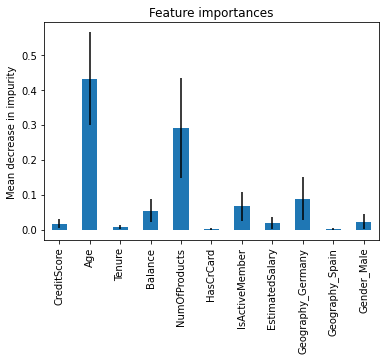

In [55]:
fig, ax = plt.subplots()
RandomForest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")

Из представленого графика можно сделать вывод о том, что наиболее значимыми параметрами являются `Age` и `NumOfProducts`

## Вывод

* В ходе предобработки данных удалены нерелевантные колонки и пустые строки, выполнена проверка на дубликаты.
* В ходе подготовки признаков категориальные признаки преобразованы в численные с помощью техники прямого кодирования OHE; Данные разделены на обучающую, валидационную и тестовую выборки в соотношении 3:1:1; Признаки масштабированы с помощью `StandardScaler`.
* В рамках исследования задачи, были обучены и проверены модели классификации DecisionTree, RandomForest и LogisticRegression, осуществлен поиск оптимальных гиперпараметров.
* Для борьбы с дисбалансом классов были применены способы взвешивания классов, увеличение выборки и уменьшение выборки.
* Оптимальный результат показала модель RandomForest с гиперпараметрами `n_estimators=40, max_depth=5` и порогом классификации 0.56.
* Метрика F1 модели на тестовой выборке равна 0.62, что выше целевой 0.59.
* Примечательно, что перебалансировка классов практически не повлияла на метрику ROC_AUC.
* Наиболее значимыми факторами при моделировании являются возраст клиента и количество используемых продуктов банка.